###  DNA Sequence Classification using Machine Learning Techniques

In [34]:

import pandas as pd
import numpy as np
import Bio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import tensorflow as tf

In [252]:
humandata = pd.read_table('human_data.txt')
humandata.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [253]:
humandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


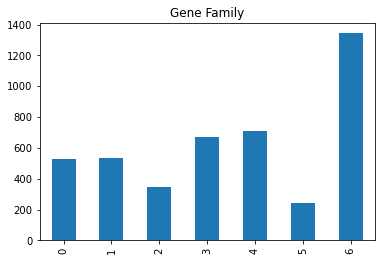

In [254]:
## 4380 Sequences are there
humandata['class'].value_counts().sort_index().plot.bar()
plt.title("Gene Family")
plt.show()

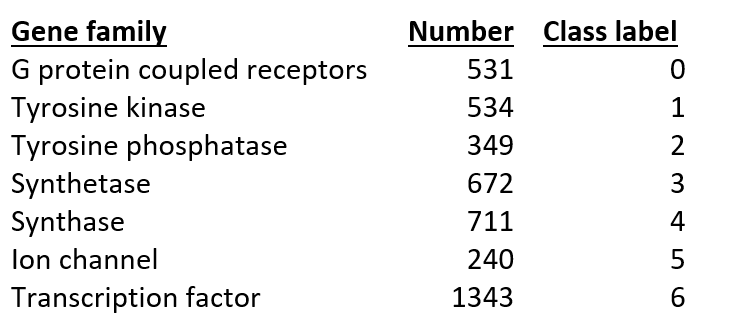

In [255]:
Image('_results_.png')

In [256]:
# The Data is somewhat Skewed  but Still lets proceed with Normal Techniques and if they are not working well 
#lets do sampling Technique like Oversampling ,UnderSampling ,SMOTE

In [257]:
display(humandata["sequence"][0])

print(f'length of Sequence 1 : {len(humandata["sequence"][0])}')

'ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG'

length of Sequence 1 : 207


In [258]:
from Bio.Seq import Seq
my_seq = Seq(humandata["sequence"][0])
print(my_seq)

ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG


In [259]:
print(f" Complement : {my_seq.complement()} \n")
print(f"Reverse Complement :  {my_seq.reverse_complement()} " )

 Complement : TACGGGGTTGATTTATGATGGCATACCGGGTGGTATTAATGGGGGTATGAGGAATGTGATAAGGAGTAGTGGGTTGATTTTTATAATTTGTGTTTGATGGTGGATGGAGGGAGTGGTTTCGGGTATTTTTATTTTTTAATATTGTTTGGGACTCTTGGTTTTACTTGCTTTTAGACAAGCGAAGTAAGTAACGGGGGTGTTAGGATC 

Reverse Complement :  CTAGGATTGTGGGGGCAATGAATGAAGCGAACAGATTTTCGTTCATTTTGGTTCTCAGGGTTTGTTATAATTTTTTATTTTTATGGGCTTTGGTGAGGGAGGTAGGTGGTAGTTTGTGTTTAATATTTTTAGTTGGGTGATGAGGAATAGTGTAAGGAGTATGGGGGTAATTATGGTGGGCCATACGGTAGTATTTAGTTGGGGCAT 


In [260]:
#The GC Content of a DNA sequence is important and relates to how stable the molecule will be

print("GC%:\t\t" + str(100 * float((my_seq.count("G") + my_seq.count("C")) / len(my_seq) ) ))


from Bio.SeqUtils import GC
print("GC% Package:\t" + str(GC(my_seq)))

GC%:		39.61352657004831
GC% Package:	39.61352657004831


In [261]:
humandata["length"] = humandata.sequence.apply(lambda x : len(x))

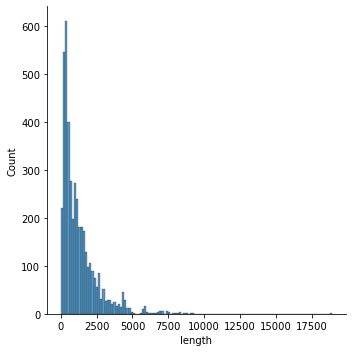

In [262]:
sns.displot(humandata["length"])

Length of the Sequence varies alot .we have to find a way to make a standard count so that we can use ML Techniques

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

In genomics, we refer to these types of manipulations as "**k-mer counting**", or counting the occurances of each possible k-mer sequence.

In [238]:

def getKmers(sequence, size=6):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [239]:
#Now we can convert our training data sequences into short overlapping k-mers of legth 6.

humandata['words'] = humandata.apply(lambda x: getKmers(x['sequence']), axis=1)

In [240]:
humandata.head()

,sequence,class,length,words
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207,"[ATGCCC, TGCCCC, GCCCCA, CCCCAA, CCCAAC, CCAAC..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681,"[ATGAAC, TGAACG, GAACGA, AACGAA, ACGAAA, CGAAA..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437,"[ATGCAA, TGCAAC, GCAACA, CAACAG, AACAGC, ACAGC..."


In [241]:
#Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert 
#the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.

In [242]:
#We are now going to Convert the words into string and then apply Count Vectorizer

humandata["in_string"] =humandata["words"].apply(lambda x:  ' '.join(x))

In [243]:
humandata[["words","in_string"]]

,words,in_string
0,"[ATGCCC, TGCCCC, GCCCCA, CCCCAA, CCCAAC, CCAAC...",ATGCCC TGCCCC GCCCCA CCCCAA CCCAAC CCAACT CAAC...
1,"[ATGAAC, TGAACG, GAACGA, AACGAA, ACGAAA, CGAAA...",ATGAAC TGAACG GAACGA AACGAA ACGAAA CGAAAA GAAA...
2,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA...",ATGTGT TGTGTG GTGTGG TGTGGC GTGGCA TGGCAT GGCA...
3,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA...",ATGTGT TGTGTG GTGTGG TGTGGC GTGGCA TGGCAT GGCA...
4,"[ATGCAA, TGCAAC, GCAACA, CAACAG, AACAGC, ACAGC...",ATGCAA TGCAAC GCAACA CAACAG AACAGC ACAGCA CAGC...
...,...,...
4375,"[ATGGAA, TGGAAG, GGAAGA, GAAGAT, AAGATT, AGATT...",ATGGAA TGGAAG GGAAGA GAAGAT AAGATT AGATTT GATT...
4376,"[ATGCAG, TGCAGT, GCAGTC, CAGTCC, AGTCCT, GTCCT...",ATGCAG TGCAGT GCAGTC CAGTCC AGTCCT GTCCTT TCCT...
4377,"[ATGCAG, TGCAGT, GCAGTC, CAGTCC, AGTCCT, GTCCT...",ATGCAG TGCAGT GCAGTC CAGTCC AGTCCT GTCCTT TCCT...
4378,"[ATGGGG, TGGGGC, GGGGCA, GGGCAC, GGCACC, GCACC...",ATGGGG TGGGGC GGGGCA GGGCAC GGCACC GCACCT CACC...


In [244]:
y=humandata.loc[:,'class'].values

In [245]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(humandata["in_string"])

In [246]:
print(X.shape)

(4380, 232414)


In [247]:
## This is ngram
cv.vocabulary_

{'atgccc tgcccc gcccca ccccaa': 52803,
 'tgcccc gcccca ccccaa cccaac': 207969,
 'gcccca ccccaa cccaac ccaact': 136621,
 'ccccaa cccaac ccaact caacta': 79202,
 'cccaac ccaact caacta aactaa': 78295,
 'ccaact caacta aactaa actaaa': 74681,
 'caacta aactaa actaaa ctaaat': 60650,
 'aactaa actaaa ctaaat taaata': 6563,
 'actaaa ctaaat taaata aaatac': 25724,
 'ctaaat taaata aaatac aatact': 101750,
 'taaata aaatac aatact atacta': 176196,
 'aaatac aatact atacta tactac': 3017,
 'aatact atacta tactac actacc': 11772,
 'atacta tactac actacc ctaccg': 46030,
 'tactac actacc ctaccg taccgt': 181326,
 'actacc ctaccg taccgt accgta': 25976,
 'ctaccg taccgt accgta ccgtat': 102780,
 'taccgt accgta ccgtat cgtatg': 180265,
 'accgta ccgtat cgtatg gtatgg': 21456,
 'ccgtat cgtatg gtatgg tatggc': 84717,
 'cgtatg gtatgg tatggc atggcc': 99209,
 'gtatgg tatggc atggcc tggccc': 163924,
 'tatggc atggcc tggccc ggccca': 187178,
 'atggcc tggccc ggccca gcccac': 53731,
 'tggccc ggccca gcccac cccacc': 211749,
 'ggccca gcccac c

In [248]:
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [249]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [250]:
print("Decision Classifier :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    dt =DecisionTreeClassifier()
    dt.fit(X[train_index],y[train_index])
    print(X[train_index].shape)
    print(y[train_index].shape)
    pred=dt.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f     F1_Score = %.5f" % (accuracy, f1))

Decision Classifier :
(3504, 232414)
(3504,)
0 Iteration : Accuracy = 0.81735     F1_Score = 0.82035
(3504, 232414)
(3504,)
1 Iteration : Accuracy = 0.82763     F1_Score = 0.83015
(3504, 232414)
(3504,)
2 Iteration : Accuracy = 0.80479     F1_Score = 0.80831
(3504, 232414)
(3504,)
3 Iteration : Accuracy = 0.81279     F1_Score = 0.81819
(3504, 232414)
(3504,)
4 Iteration : Accuracy = 0.79452     F1_Score = 0.79767


In [29]:
print("Random Forest Classifier :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    rf = RandomForestClassifier(n_jobs=-1)
    rf.fit(X[train_index],y[train_index])
    pred=rf.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f     F1_Score = %.5f" % (accuracy, f1))

Random Forest Classifier :


NameError: name 'RandomForestClassifier' is not defined

In [93]:
## Used Grid Search to find the best Hyperparameters. 
from sklearn.naive_bayes import MultinomialNB
print("Naive Bayes Classifier :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    classifier = MultinomialNB(alpha=0.1)
    classifier.fit(X[train_index],y[train_index])
    pred=classifier.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f    F1_Score = %.5f" % (accuracy, f1))

Naive Bayes Classifier :
0 Iteration : Accuracy = 0.98059    F1_Score = 0.98061
1 Iteration : Accuracy = 0.98059    F1_Score = 0.98066
2 Iteration : Accuracy = 0.97603    F1_Score = 0.97606
3 Iteration : Accuracy = 0.97717    F1_Score = 0.97722
4 Iteration : Accuracy = 0.97717    F1_Score = 0.97715


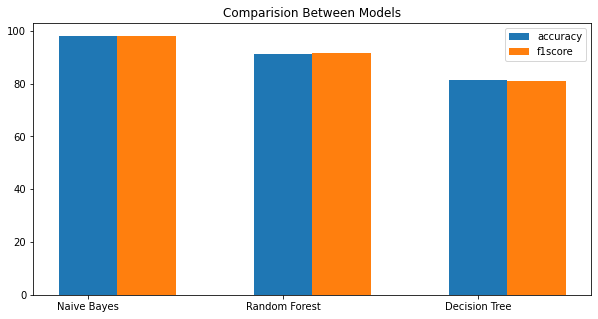

In [94]:
#scores ={"Naive Bayes":98.059  ,"Random Forest":91.4 ,"Decision Tree": 81.5}
plt.figure(figsize=(10,5))
scores=["Naive Bayes","Random Forest","Decision Tree"]
accscore=[98.059,91.4,81.5]
f1score=[98.061,91.5,81.1]
w=0.3
bar1=np.arange(len(scores))
bar2=[i+w for i in bar1]

plt.bar(bar1,accscore,w,label="accuracy")
plt.bar(bar2,f1score,w,label="f1score")
plt.xticks(bar1, scores)
plt.legend()
plt.title("Comparision Between Models")
plt.show()


In [95]:
print(bar1)
print(bar2)

[0 1 2]
[0.3, 1.3, 2.3]


In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=42)
nb_ =MultinomialNB(alpha=0.01)
nb_.fit(X_train, y_train)

y_pred = nb_.predict(X_test)
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    0   0    3
1           0  100   0    0    0   0    6
2           0    0  78    0    0   0    0
3           0    0   0  122    0   0    3
4           0    0   0    0  143   0    6
5           0    0   0    0    0  51    0
6           0    0   0    0    0   0  265


In [97]:
import pickle

In [98]:
filename = 'finalized_model.sav'
pickle.dump(nb_, open(filename, 'wb'))

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

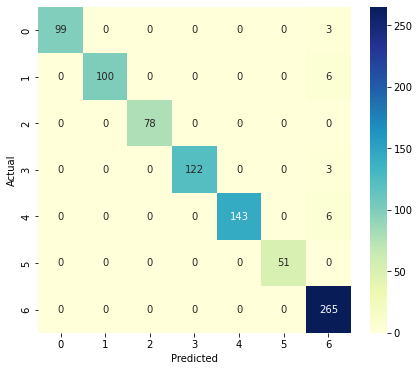

In [99]:
plt.figure(figsize=(7,6))
sns.heatmap(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')),cmap="YlGnBu",annot=True,fmt='d')

##### Using TFIDF Vectorization

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(4,4))
X_tf = tf.fit_transform(humandata["in_string"])

In [101]:
tf.vocabulary_

{'atgccc tgcccc gcccca ccccaa': 52803,
 'tgcccc gcccca ccccaa cccaac': 207969,
 'gcccca ccccaa cccaac ccaact': 136621,
 'ccccaa cccaac ccaact caacta': 79202,
 'cccaac ccaact caacta aactaa': 78295,
 'ccaact caacta aactaa actaaa': 74681,
 'caacta aactaa actaaa ctaaat': 60650,
 'aactaa actaaa ctaaat taaata': 6563,
 'actaaa ctaaat taaata aaatac': 25724,
 'ctaaat taaata aaatac aatact': 101750,
 'taaata aaatac aatact atacta': 176196,
 'aaatac aatact atacta tactac': 3017,
 'aatact atacta tactac actacc': 11772,
 'atacta tactac actacc ctaccg': 46030,
 'tactac actacc ctaccg taccgt': 181326,
 'actacc ctaccg taccgt accgta': 25976,
 'ctaccg taccgt accgta ccgtat': 102780,
 'taccgt accgta ccgtat cgtatg': 180265,
 'accgta ccgtat cgtatg gtatgg': 21456,
 'ccgtat cgtatg gtatgg tatggc': 84717,
 'cgtatg gtatgg tatggc atggcc': 99209,
 'gtatgg tatggc atggcc tggccc': 163924,
 'tatggc atggcc tggccc ggccca': 187178,
 'atggcc tggccc ggccca gcccac': 53731,
 'tggccc ggccca gcccac cccacc': 211749,
 'ggccca gcccac c

In [102]:
tf.idf_

array([5.49321199, 6.05282778, 5.15092578, ..., 6.74597496, 6.74597496,
       6.98713702])

In [103]:
print("Naive Bayes Classifier for TFidf:")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X_tf,y)):
    classifier = MultinomialNB(alpha=0.1)
    classifier.fit(X[train_index],y[train_index])
    pred=classifier.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f    F1_Score = %.5f" % (accuracy, f1))

Naive Bayes Classifier for TFidf:
0 Iteration : Accuracy = 0.98059    F1_Score = 0.98061
1 Iteration : Accuracy = 0.98059    F1_Score = 0.98066
2 Iteration : Accuracy = 0.97603    F1_Score = 0.97606
3 Iteration : Accuracy = 0.97717    F1_Score = 0.97722
4 Iteration : Accuracy = 0.97717    F1_Score = 0.97715


In [ ]:
print("Random Forest Classifier for Tfidf :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X_tf,y)):
    rf = RandomForestClassifier(n_jobs=-1)
    rf.fit(X[train_index],y[train_index])
    pred=rf.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f     F1_Score = %.5f" % (accuracy, f1))

### Testing our Model on  Chimpanzee data and Dog Data

In [43]:
chimp = pd.read_table('chimp_data.txt')
dog = pd.read_table('dog_data.txt')
chimp.head()
dog.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


In [191]:
chimp['words'] = chimp.apply(lambda x: getKmers(x['sequence']), axis=1)
dog['words'] = dog.apply(lambda x: getKmers(x['sequence']), axis=1)

In [45]:
chimp_texts = list(chimp['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_c = chimp.iloc[:, 1].values                       # y_c for chimp

dog_texts = list(dog['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_d = dog.iloc[:, 1].values        

In [46]:
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [47]:
print(X_chimp.shape)
print(X_dog.shape)

(1682, 232414)
(820, 232414)


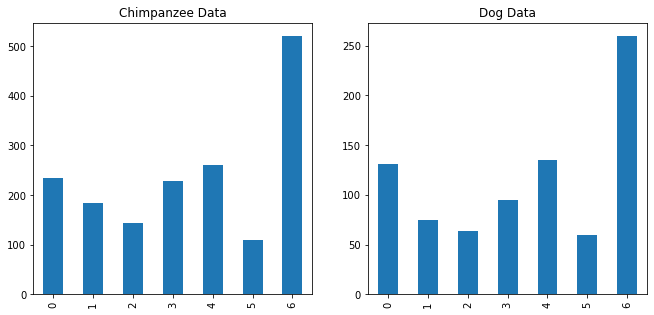

In [48]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
chimp['class'].value_counts().sort_index().plot.bar()
plt.title("Chimpanzee Data");
plt.subplot(1,2,2)
dog['class'].value_counts().sort_index().plot.bar()
plt.title("Dog Data");

In [49]:
# Predicting the chimp, dog and worm sequences
y_pred_chimp = nb_.predict(X_chimp)
y_pred_dog = nb_.predict(X_dog)

NameError: name 'nb_' is not defined

In [157]:
# performance on chimp genes
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_c, name='Actual'), pd.Series(y_pred_chimp, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_c, y_pred_chimp)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          231    0    0    0    0    0    3
1            0  179    0    0    0    0    6
2            0    0  144    0    0    0    0
3            0    0    0  225    0    0    3
4            1    0    0    0  253    0    7
5            0    0    0    0    0  109    0
6            0    0    0    0    0    0  521
accuracy = 0.988 
precision = 0.989 
recall = 0.988 
f1 = 0.988


In [158]:
# performance on dog genes
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_d, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_d, y_pred_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    0   1   2   3    4   5    6
Actual                                  
0          124   0   0   0    0   0    7
1            0  52   0   0    0   0   23
2            0   0  43   0    0   0   21
3            1   0   0  64    1   0   29
4            0   0   0   0  110   0   25
5            0   0   0   0    0  40   20
6            0   0   0   0    0   0  260
accuracy = 0.845 
precision = 0.894 
recall = 0.845 
f1 = 0.847


### The model seems to perform well on human data. It also does on Chimpanzee. That might not be a surprize since the chimp and human are so similar genetically. The performance on dog is not quite as good. We would expect this since the dog is more divergent from human than the chimpanze.

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/hsequence.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/hlabel.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

  

Example sequence
-----------------------
DNA Sequence #1:
 404: Not F ...  Not Found
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Labels:
 [['404: Not Found']]
One-hot encoded labels:
 [[1.]]


ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

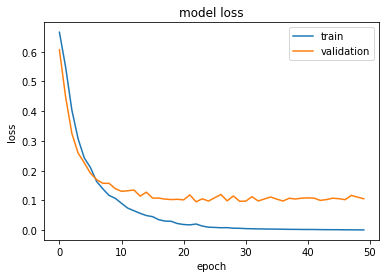

In [279]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

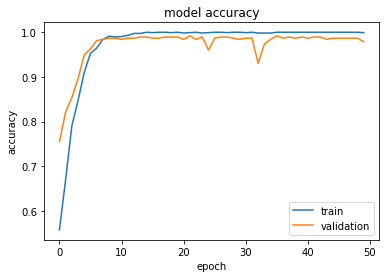

In [189]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

16/16 [==============================] - 0s 2ms/step
Confusion matrix:
 [[252   7]
 [  0 241]]


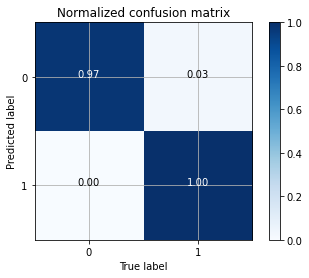

In [190]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [192]:
print(chimp)

                                               sequence  class  \
0     ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...      4   
1     ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...      4   
2     ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4   
3     ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4   
4     ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...      6   
...                                                 ...    ...   
1677  ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...      5   
1678  ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...      5   
1679  ATGAAGCGACCCAAGGAGCCGAGCGGCTCCGACGGGGAGTCCGACG...      6   
1680  ATGACTGGAACCCCAAAGACTCAAGAAGGAGCTAAAGATCTTGAAG...      3   
1681  ATGTTGCCCAGCTGTGGCAAGATCTTGACTGGGTGTAAGAATATGC...      3   

                                                  words  
0     [ATGCCC, TGCCCC, GCCCCA, CCCCAA, CCCAAC, CCAAC...  
1     [ATGAAC, TGAACG, GAACGA, AACGAA, ACGAAA, CGAAA...  
2     [ATGGCC, TGGCCT, GGCCTC, GC

In [215]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, test_size=0.20, random_state=42)
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(3504, 232414)))
model.add(MaxPooling1D(pool_size=4, strides=5, padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 3493, 32)          89247008  
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 699, 32)          0         
 g1D)                                                            
                                                                 
 flatten_52 (Flatten)        (None, 22368)             0         
                                                                 
 dense_98 (Dense)            (None, 128)               2863232   
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 flatten_53 (Flatten)        (None, 128)               0         
                                                     

In [208]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=1)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[2] = [0,74510] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [220]:
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    print(X[train_index].shape)
    print(y[train_index].shape)
    model.fit(X[train_index],y[train_index])
    #pred=model.predict(X[val_index])
    #accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    #print(str(i)+" Iteration : Accuracy = %.5f     F1_Score = %.5f" % (accuracy, f1))

(3504, 232414)
(3504,)


InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[2] = [0,136621] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [251]:
print(X[train_index])
print(y[train_index])

  (0, 52803)	1
  (0, 207969)	1
  (0, 136621)	1
  (0, 79202)	1
  (0, 78295)	2
  (0, 74681)	2
  (0, 60650)	1
  (0, 6563)	1
  (0, 25724)	1
  (0, 101750)	1
  (0, 176196)	1
  (0, 3017)	1
  (0, 11772)	1
  (0, 46030)	1
  (0, 181326)	1
  (0, 25976)	1
  (0, 102780)	1
  (0, 180265)	1
  (0, 21456)	1
  (0, 84717)	1
  (0, 99209)	1
  (0, 163924)	1
  (0, 187178)	1
  (0, 53731)	1
  (0, 211749)	1
  :	:
  (3503, 198518)	1
  (3503, 164856)	1
  (3503, 150748)	1
  (3503, 134240)	1
  (3503, 212199)	1
  (3503, 153025)	1
  (3503, 142876)	1
  (3503, 103635)	1
  (3503, 19522)	1
  (3503, 39966)	1
  (3503, 157552)	1
  (3503, 232202)	1
  (3503, 231582)	1
  (3503, 15135)	1
  (3503, 20267)	1
  (3503, 79879)	1
  (3503, 80930)	1
  (3503, 105544)	1
  (3503, 227125)	1
  (3503, 132325)	1
  (3503, 156977)	1
  (3503, 17192)	1
  (3503, 115050)	1
  (3503, 98593)	1
  (3503, 170831)	1
[4 4 3 ... 6 6 6]
